In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('FinancialIndicators.csv')
Fin=df[df.columns[5:28]]
train_set=Fin[0:480]
test_set=Fin[480:Fin.shape[0]]

In [6]:
# Correlation matrix plot function 
from matplotlib import pyplot as plt
from matplotlib.collections import EllipseCollection

def plot_corr_ellipses(data, ax=None, **kwargs):

    M = np.array(data)
    if not M.ndim == 2:
        raise ValueError('data must be a 2D array')
    if ax is None:
        fig, ax = plt.subplots(1, 1, subplot_kw={'aspect':'equal'})
        ax.set_xlim(-0.5, M.shape[1] - 0.5)
        ax.set_ylim(-0.5, M.shape[0] - 0.5)

    # xy locations of each ellipse center
    xy = np.indices(M.shape)[::-1].reshape(2, -1).T

    # set the relative sizes of the major/minor axes according to the strength of
    # the positive/negative correlation
    w = np.ones_like(M).ravel()
    h = 1 - np.abs(M).ravel()
    a = 45 * np.sign(M).ravel()

    ec = EllipseCollection(widths=w, heights=h, angles=a, units='x', offsets=xy,
                           transOffset=ax.transData, array=M.ravel(), **kwargs)
    ax.add_collection(ec)

    # if data is a DataFrame, use the row/column names as tick labels
    if isinstance(data, pd.DataFrame):
        ax.set_xticks(np.arange(M.shape[1]))
        ax.set_xticklabels(data.columns, rotation=90)
        ax.set_yticks(np.arange(M.shape[0]))
        ax.set_yticklabels(data.index)

    return ec

# Correlation matrix

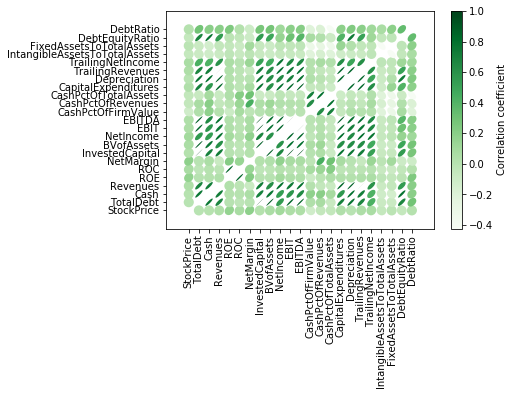

In [4]:
%matplotlib inline

fig, ax = plt.subplots(1, 1)
m = plot_corr_ellipses(train_set.corr(), ax=ax, cmap='Greens')
cb = fig.colorbar(m)
cb.set_label('Correlation coefficient')
ax.margins(0.1)

# The Full Model:

In [3]:
import statsmodels.api as sm
model = sm.OLS(train_set['StockPrice'], sm.add_constant(train_set[train_set.columns[1:23]]))
results = model.fit()
print (results.summary())

C:\Users\imelvis\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                            OLS Regression Results                            
Dep. Variable:             StockPrice   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     2.931
Date:                Sun, 04 Feb 2018   Prob (F-statistic):           1.85e-05
Time:                        20:46:08   Log-Likelihood:                -2385.3
No. Observations:                 480   AIC:                             4815.
Df Residuals:                     458   BIC:                             4906.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

# The Full Model (ctd) 
* OLS() from statsmodels.api fit a linear regression
* R-square is only ~12%
* Most of the predictors are statistically insignificant (i.e. high p-values)
* It is reported that the design matric is singular
    * R will report which vairable causes singularity and automatically ignore such variables
    * From R, it shows that 'Depreciation' 
    * However, python still keep this predictor

# Variable Selection
* From the full model, we notice that not many of the predictors are significant, so we may select a subset which mainly contains the significant ones
* Selection methods:
    * Best subset
    * Stepwise selection (AIC)
    * Principal component regression
    * LASSO


# Best subset selection
* Unfortunately python has no package in doing best subset selection
* We find a self-define function of it from Internet and modify a little bit for instance
    * only Adj-Rsquare is implemented so far
* The modified function is given below
    * Notice that the implementation is so staright forward and it takes 3-4 hours to go through every possible model for 22 predictors!
    * So we add the third input of the function to be the termination condition
        * It is the maximum number of predictors in the final model, say $k$
        * say $k=5$, it goes through $C_1^{22}+C_2^{22}+C_3^{22}+C_4^{22}+C_5^{22}$ possible model
        * We take 8 as the maximum number as demo below
            * by setting $maxv=8$

In [8]:
#self-define function for best subset selection (by Adj-Rsquare only)
from itertools import chain, combinations
import statsmodels.api as sm
def best_subset(X, y, maxv):
    n_features = X.shape[1]
    subsets = chain.from_iterable(combinations(range(n_features), k+1) for k in range(maxv))
    best_score = -np.inf
    best_subset = None
    history=[0 for k in range(maxv)]
    k=1
    for subset in subsets:
        lin_reg = sm.OLS(y, sm.add_constant(X.iloc[:, list(subset)])).fit()
        score = lin_reg.rsquared
        if score > best_score:
            best_score, best_subset = score, subset
            history[len(subset)-1]=lin_reg.rsquared_adj
    best_subset=np.array(best_subset)+1
    return best_subset, history

# The resulting model (maxv=8 here)
* Turns out 8 predictors is the best in terms of Adj_Rsquare

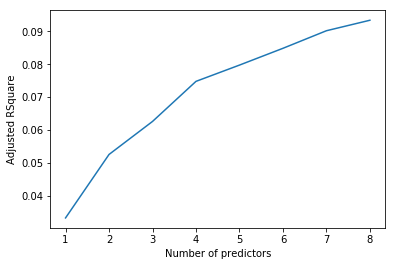

In [12]:
best_subset_index,Adj_history=best_subset(train_set[train_set.columns[1:23]],train_set['StockPrice'],maxv=8)
import matplotlib.pyplot as plt
plt.plot(range(1,len(Adj_history)+1),Adj_history)
plt.xlabel('Number of predictors')
plt.ylabel('Adjusted RSquare')
plt.show()

In [13]:
best_subset_m=sm.OLS(train_set['StockPrice'], sm.add_constant(train_set[train_set.columns[best_subset_index]])).fit()
print (best_subset_m.summary())

                            OLS Regression Results                            
Dep. Variable:             StockPrice   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     7.168
Date:                Mon, 05 Feb 2018   Prob (F-statistic):           5.65e-09
Time:                        09:50:32   Log-Likelihood:                -2388.0
No. Observations:                 480   AIC:                             4794.
Df Residuals:                     471   BIC:                             4831.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

# Stepwise Selection (AIC)
* Again, python has no related library to make it done
* We found a self-define function on Internet for **Forward selection**

In [14]:
#self-define function for Forward Selection (AIC)
#Notice that the method below only check for the AIC of the current model without consider the R-square
# and stop once there is no improvment on AIC

import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
import functools
import re



def reduce_concat(x, sep=""):
    return functools.reduce(lambda x, y: str(x) + sep + str(y), x)


def forward_selected(data,null_formula,full_formula,response,intercept):
    """Linear model designed by forward selection.
    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response
    response: string, name of response column in data
    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by aic
    """

    
    null_temp        = re.split('~',null_formula)
    null_predic_com  = null_temp[1].split('+')
    null_predic      = null_predic_com[1:len(null_predic_com)]
    full_temp        = re.split('~',full_formula)
    full_predic_com  = full_temp[1].split('+')
    full_predic      = full_predic_com[1:len(full_predic_com)]
    indices          = [i for i,id in enumerate(full_predic) if id not in null_predic]
    domain           = [full_predic[i] for i in indices]

    start            = set(null_predic)
    remaining        = set(domain)
    selected         = null_predic
    current_score, best_new_score = 10000000, 10000000
    score_aic        = []
    variable_added   = []
    flag=0
    step=np.max(indices)+1
    
    while (remaining and current_score == best_new_score and step >0):
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {}".format(response,' + '.join(selected + [candidate]))

            if intercept ==0:
                formula = formula + "-1"
            score = smf.ols(formula, data).fit().aic
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop(0)
        if current_score > best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            score_aic.append(best_new_score)
            variable_added.append(best_candidate)
            current_score = best_new_score
        step=step-1
    formula = "{} ~ {}".format(response,' + '.join(selected))

    if intercept ==0:
        formula = formula + "-1"
    model =smf.ols(formula, data).fit()
    return model
    
 

In [15]:
all_columns = "+".join(train_set.columns[1:23])
my_formula="StockPrice~"+all_columns
forward_var=forward_selected(data=train_set,null_formula='StockPrice~1',full_formula=my_formula,response='StockPrice',intercept=1)
forward_var.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             StockPrice   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     8.255
Date:                Mon, 05 Feb 2018   Prob (F-statistic):           1.63e-08
Time:                        10:14:20   Log-Likelihood:                -2391.6
No. Observations:                 480   AIC:                             4797.
Df Residuals:                     473   BIC:                             4826.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        41.5479      5.106      8.137      0.000      31.515      51.581
NetMargin                       155.7752     32.938      4.729      0.000      91.053     220.498
CashPctOfRevenues               -34.6451     10.176     -3.405      0.001     -54.641     -14.649
ROE                              40.1473     16.868      2.380      0.018       7.002      73.292
ROC                             -10.1063      5.999     -1.685      0.093     -21.895       1.682
IntangibleAssetsToTotalAssets   -31.3788     10.910     -2.876      0.004     -52.817      -9.941
FixedAssetsToTotalAssets        -26.4960      9.459     -2.801      0.005     -45.082      -7.910
==============================================================================
Omnibus:                      897.262   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           890214.110
Skew:                          12.021   Prob(JB):                         0.00
Kurtosis:                     212.601   Cond. No.                         24.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# LASSO
* **LassoLarsCV** from **sklearn.linear_model** library executes LASSO
    * it helps to determine the best lambda in LASSO by cross validation
        * Number of folds set to be 10 here
        * It determine the best lambda by the one minimizes the average MSE from K-fold cross validation
            * Note that python uses alpha to define the regularization parameter, and they are reciprocal to each other
        * by setting **max_n_alphas =2** to draw the full solution path
        * without setting **max_n_alphas** to select variables
            * Note that the result may vary from time to time since we form the folds randomly


* Generate a full solution path 

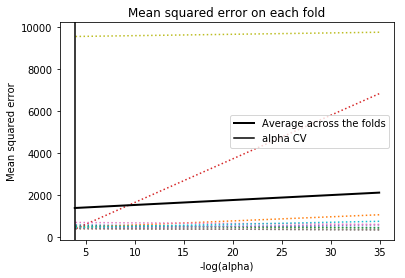

alpha:0.02053


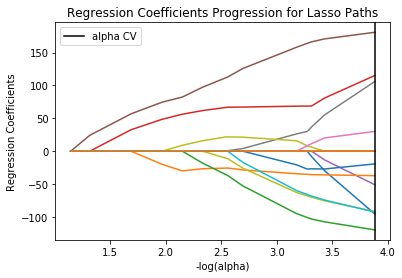

In [16]:
from sklearn.linear_model import LassoLarsCV
from sklearn.model_selection import KFold
import matplotlib.pylab as plt
lasso_full_sol=LassoLarsCV(cv=KFold(n_splits=10,shuffle=True),max_n_alphas =2).fit(train_set[train_set.columns[1:23]].values,train_set['StockPrice'].values)

m_log_alphascv = -np.log(lasso_full_sol.cv_alphas_)
plt.figure()
plt.plot(m_log_alphascv, lasso_full_sol.mse_path_, ':')
plt.plot(m_log_alphascv, lasso_full_sol.mse_path_.mean(axis=-1), 'k',
label='Average across the folds', linewidth=2)
plt.axvline(-np.log(lasso_full_sol.alpha_), linestyle='-', color='k',
label='alpha CV')
plt.legend()
plt.xlabel('-log(alpha)')
plt.ylabel('Mean squared error')
plt.title('Mean squared error on each fold')
plt.show()

print ("alpha:%.5f"  % lasso_full_sol.alpha_)


m_log_alphas = -np.log(lasso_full_sol.alphas_)
ax = plt.gca()
plt.plot(m_log_alphas, lasso_full_sol.coef_path_.T)
plt.axvline(-np.log(lasso_full_sol.alpha_), linestyle='-', color='k',
label='alpha CV')
plt.ylabel('Regression Coefficients')
plt.legend()
plt.xlabel('-log(alpha)')
plt.title('Regression Coefficients Progression for Lasso Paths')
plt.show()

* Execute LASSO

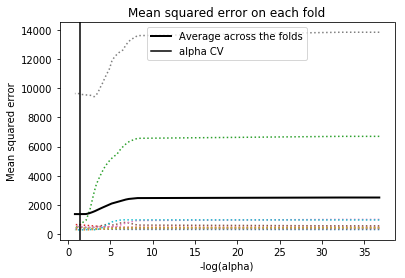

aplha:0.23429


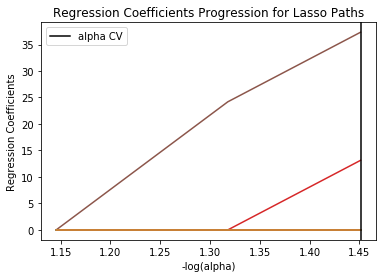

In [18]:
from sklearn.linear_model import LassoLarsCV
from sklearn.model_selection import KFold
import matplotlib.pylab as plt
lasso_fit=LassoLarsCV(cv=KFold(n_splits=10,shuffle=True)).fit(train_set[train_set.columns[1:23]].values,train_set['StockPrice'].values)

m_log_alphascv = -np.log(lasso_fit.cv_alphas_)
plt.figure()
plt.plot(m_log_alphascv, lasso_fit.mse_path_, ':')
plt.plot(m_log_alphascv, lasso_fit.mse_path_.mean(axis=-1), 'k',
label='Average across the folds', linewidth=2)
plt.axvline(-np.log(lasso_fit.alpha_), linestyle='-', color='k',
label='alpha CV')
plt.legend()
plt.xlabel('-log(alpha)')
plt.ylabel('Mean squared error')
plt.title('Mean squared error on each fold')
plt.show()

print ("aplha:%.5f" % lasso_fit.alpha_)

m_log_alphas = -np.log(lasso_fit.alphas_)
ax = plt.gca()
plt.plot(m_log_alphas, lasso_fit.coef_path_.T)
plt.axvline(-np.log(lasso_fit.alpha_), linestyle='-', color='k',
label='alpha CV')
plt.ylabel('Regression Coefficients')
plt.legend()
plt.xlabel('-log(alpha)')
plt.title('Regression Coefficients Progression for Lasso Paths')
plt.show()

* Selected predictors:

In [19]:
pd.DataFrame(data = {'predictors':list(train_set.columns[1:23]),'coefficients':lasso_fit.coef_})

,coefficients,predictors
0,0.000000,TotalDebt
1,0.000000,Cash
2,0.000000,Revenues
3,2.822432,ROE
4,0.000000,ROC
5,27.057877,NetMargin
6,0.000000,InvestedCapital
7,0.000000,BVofAssets
8,0.000000,NetIncome
9,0.000000,EBIT


# Principal Component Regression
* **PCA()** from **sklearn.decomposition** library is used to execute the decompose the principal component
    * **pca.explained_variance_ratio__ ** returns the percentage of variation explained by the each components  
* **model_selection()** from **sklearn** library hepls to compute the MSE of cross validation across the number of components
    * One may determine the best choice of number of components by the minimizer of the MSE or/and the % of explained variation
    * For the cross validation, 10 folds is a typical choice
    * Note that the result may vary since the split of fold is random

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn import model_selection

pca = PCA()
X_reduced = pca.fit_transform(scale(train_set[train_set.columns[1:23]]))
print ("Comp1 to Comp5 Var. Expalined.: ",np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)[0:5])
print ("Comp6 to Comp10 Var. Expalined.: ",np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)[5:10])
print ("Comp11 to Comp15 Var. Expalined.: ",np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)[10:15])
print ("Comp16 to Comp20 Var. Expalined.: ",np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)[15:20])


Comp1 to Comp5 Var. Expalined.:  [ 43.56  57.01  65.97  73.39  79.94]
Comp6 to Comp10 Var. Expalined.:  [ 84.88  88.84  92.11  94.04  95.54]
Comp11 to Comp15 Var. Expalined.:  [ 96.7   97.72  98.37  98.89  99.26]
Comp16 to Comp20 Var. Expalined.:  [  99.59   99.86   99.97  100.01  100.02]


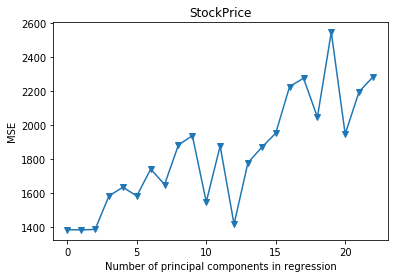

In [21]:
# 10-fold CV, with shuffle
n = len(X_reduced)
kf_10 = model_selection.KFold( n_splits=10, shuffle=True)
y=train_set['StockPrice']

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*model_selection.cross_val_score(regr, np.ones((n,1)), y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 22 principle components, adding one component at the time.
for i in np.arange(1, 23):
    score = -1*model_selection.cross_val_score(regr, X_reduced[:,:i], y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
# Plot results    
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('StockPrice')
plt.xlim(xmin=-1)
plt.show()

* 10 components is a good choice since it explains around 95% variation and the MSE is relative low

In [40]:
import statsmodels.api as sm
num_comp=10
pcr_model = sm.OLS(y, sm.add_constant(X_reduced[:,:num_comp]))
results = pcr_model.fit()
print (results.summary())

                            OLS Regression Results                            
Dep. Variable:          logStockPrice   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     11.88
Date:                Mon, 05 Feb 2018   Prob (F-statistic):           2.35e-18
Time:                        10:46:25   Log-Likelihood:                -374.63
No. Observations:                 480   AIC:                             771.3
Df Residuals:                     469   BIC:                             817.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5150      0.024    144.143      0.0

# Model Inadequacy
* Most of the predictors left in the models are significant, but the Adjusted R-squares are still low
* By taking another look of the data, it may help to figure out the reason and improve the model
    * Let’s take a snapshot on the scatterplot matrix of some variables


C:\Users\imelvis\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


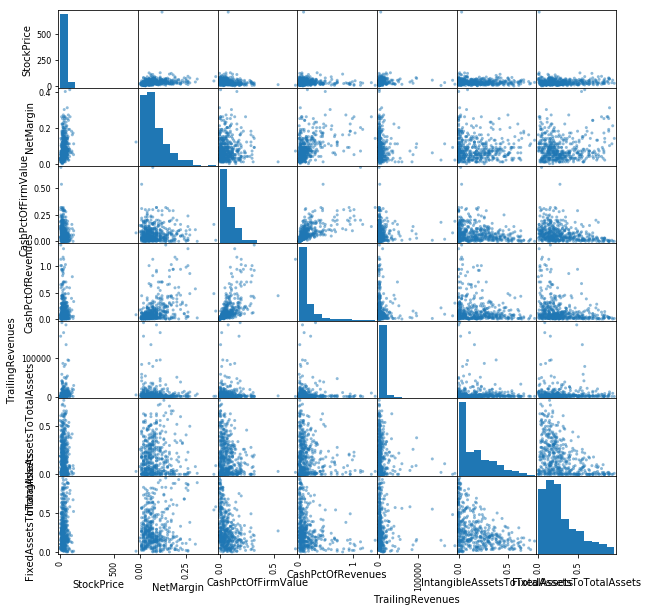

In [24]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(train_set[train_set.columns[list({0,6,12,13,17,19,20})]],figsize=(10, 10))
plt.show()

* Histograms of each individual variables show non-symmetric shape
    * Extremely right-skew
    * Not surprising since each measure of these variables cannot be negative by design
    * It is quite common in business and financial data; A few big companies come with extremely large values
* Each predictor shows a nonlinear relationship with Stock Price
* These suggest transformation may be needed


# Data transformation 
* For business data, there are some typical transformations:
    * Log(x), 1/x and sqrt(x)
    * We may apply the above on our dataset to see any improvement in terms of skewness and the linear relationship 


* Snapshot of log transformation:


In [23]:
# log transformation
log_train_set=np.log(train_set+0.000001)
log_test_set=np.log(test_set+0.000001)
log_train_set.columns="log"+log_train_set.columns
log_test_set.columns="log"+log_test_set.columns

C:\Users\imelvis\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """Entry point for launching an IPython kernel.


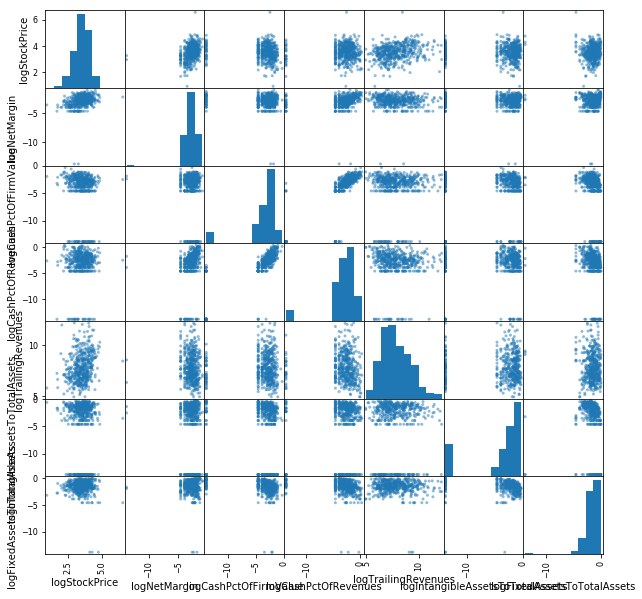

In [28]:
scatter_matrix(log_train_set[log_train_set.columns[list({0,6,12,13,17,19,20})]],figsize=(10, 10))
plt.show()

* Snapshot of 1/x:


C:\Users\imelvis\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  


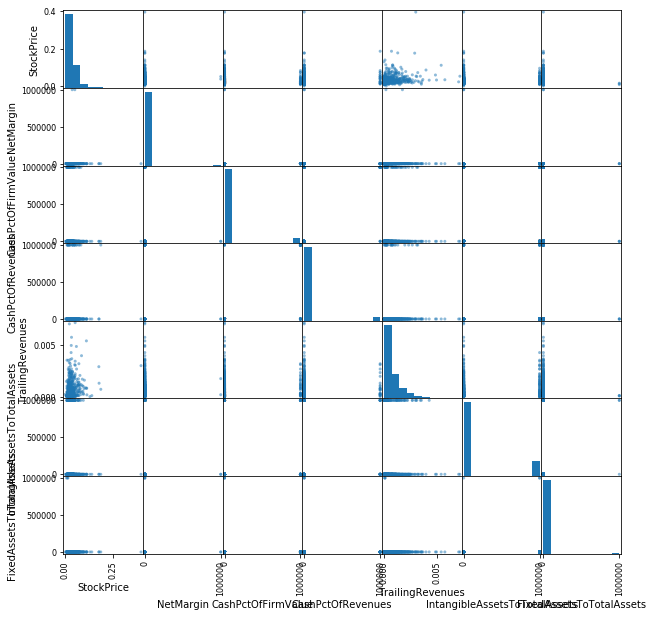

In [33]:
temp=1/(train_set+0.000001)
scatter_matrix(temp[temp.columns[list({0,6,12,13,17,19,20})]],figsize=(10, 10))
plt.show()

* Snapshot of sqrt(x):

C:\Users\imelvis\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  


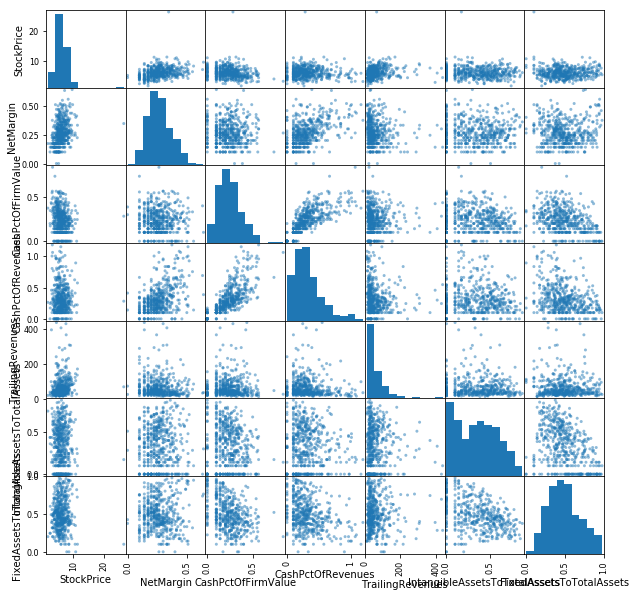

In [34]:
temp=np.sqrt(train_set)
scatter_matrix(temp[temp.columns[list({0,6,12,13,17,19,20})]],figsize=(10, 10))
plt.show()

* Comment:
    * 1/x does not really help in the shape of the histograms and the linear relationship with the Stockprice
    * Sqrt helps in the shape but not really help in the linear relationship
    * But we found a balance between shape of the histogram and linear relationship by using log transformation


# Log Transformation
* By log transformation on all variables: 
    * Shape of relationships (see the scatterplot next page):
        * Many of the data patterns now resemble a linear trend
        * For instance, log(StockPrice) and log(Net Margin) has a stronger linear relationship now
* Remark: As some of the observations are 0 (e.g. Total debt) which is not able to apply log function, so we adjust the whole dataset by adding a very small number  


C:\Users\imelvis\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """Entry point for launching an IPython kernel.


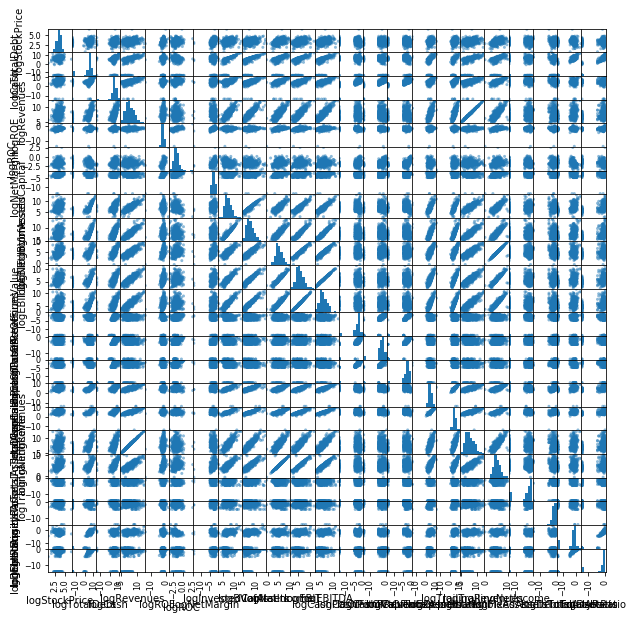

In [35]:
scatter_matrix(log_train_set,figsize=(10, 10))
plt.show()

# Selection again

* Best Subset (take **maxv=8** here)

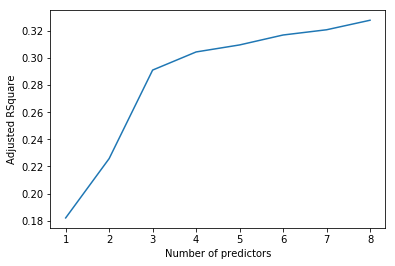

In [53]:
log_best_subset_index,Adj_history=best_subset(log_train_set[log_train_set.columns[1:23]],log_train_set['logStockPrice'],maxv=8)
import matplotlib.pyplot as plt
plt.plot(range(1,len(Adj_history)+1),Adj_history)
plt.xlabel('Number of predictors')
plt.ylabel('Adjusted RSquare')
plt.show()

In [54]:
log_best_subset_m=sm.OLS(log_train_set['logStockPrice'], sm.add_constant(log_train_set[log_train_set.columns[log_best_subset_index]])).fit()
print (log_best_subset_m.summary())

                            OLS Regression Results                            
Dep. Variable:          logStockPrice   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     30.20
Date:                Mon, 05 Feb 2018   Prob (F-statistic):           4.01e-38
Time:                        12:03:16   Log-Likelihood:                -329.45
No. Observations:                 480   AIC:                             676.9
Df Residuals:                     471   BIC:                             714.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      3

* Forward selection

In [55]:
log_all_columns = "+".join(log_train_set.columns[1:23])
log_my_formula="logStockPrice~"+log_all_columns
log_forward_var=forward_selected(data=log_train_set,null_formula='logStockPrice~1',full_formula=log_my_formula,response='logStockPrice',intercept=1)
log_forward_var.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          logStockPrice   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     27.08
Date:                Mon, 05 Feb 2018   Prob (F-statistic):           9.93e-38
Time:                        12:03:24   Log-Likelihood:                -328.58
No. Observations:                 480   AIC:                             677.2
Df Residuals:                     470   BIC:                             718.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  3.1827      0.185     17.192      0.000       2.819       3.546
logNetIncome               0.3961      0.066      6.017      0.000       0.267       0.525
logRevenues               -1.9972      0.278     -7.193      0.000      -2.543      -1.452
logTrailingRevenues        1.9119      0.278      6.870      0.000       1.365       2.459
logCapitalExpenditures    -0.0490      0.014     -3.404      0.001      -0.077      -0.021
logCashPctOfFirmValue     -0.0418      0.014     -3.013      0.003      -0.069      -0.015
logBVofAssets             -0.1427      0.045     -3.206      0.001      -0.230      -0.055
logCashPctOfRevenues       0.0358      0.016      2.293      0.022       0.005       0.067
logDebtRatio               0.0127      0.006      2.218      0.027       0.001       0.024
logNetMargin              -0.0759      0.045     -1.671      0.095      -0.165       0.013
==============================================================================
Omnibus:                       19.913   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.930
Skew:                          -0.092   Prob(JB):                     2.37e-11
Kurtosis:                       4.553   Cond. No.                         293.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* LASSO

C:\Users\imelvis\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


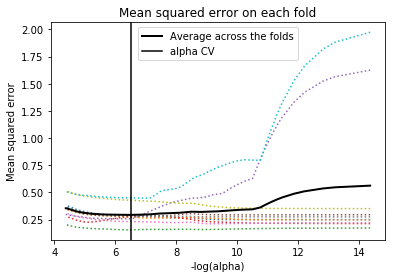

aplha:0.00147


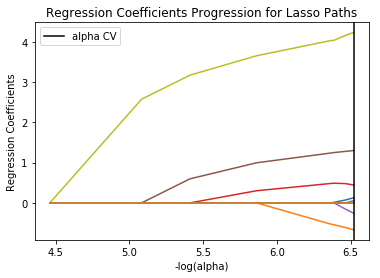

,coefficients,predictors
0,0.000923,logTotalDebt
1,0.000000,logCash
2,0.000000,logRevenues
3,0.024056,logROE
4,0.004218,logROC
5,0.055645,logNetMargin
6,0.000000,logInvestedCapital
7,0.000000,logBVofAssets
8,0.128779,logNetIncome
9,0.000000,logEBIT


In [32]:
from sklearn.linear_model import LassoLarsCV
from sklearn.model_selection import KFold
import matplotlib.pylab as plt
log_lasso_fit=LassoLarsCV(cv=KFold(n_splits=10,shuffle=True)).fit(log_train_set[log_train_set.columns[1:23]].values,log_train_set['logStockPrice'].values)

m_log_alphascv = -np.log(log_lasso_fit.cv_alphas_)
plt.figure()
plt.plot(m_log_alphascv, log_lasso_fit.mse_path_, ':')
plt.plot(m_log_alphascv, log_lasso_fit.mse_path_.mean(axis=-1), 'k',
label='Average across the folds', linewidth=2)
plt.axvline(-np.log(log_lasso_fit.alpha_), linestyle='-', color='k',
label='alpha CV')
plt.legend()
plt.xlabel('-log(alpha)')
plt.ylabel('Mean squared error')
plt.title('Mean squared error on each fold')
plt.show()

print ("aplha:%.5f" % log_lasso_fit.alpha_)


m_log_alphas = -np.log(log_lasso_fit.alphas_)
ax = plt.gca()
plt.plot(m_log_alphas, log_lasso_fit.coef_path_.T)
plt.axvline(-np.log(log_lasso_fit.alpha_), linestyle='-', color='k',
label='alpha CV')
plt.ylabel('Regression Coefficients')
plt.legend()
plt.xlabel('-log(alpha)')
plt.title('Regression Coefficients Progression for Lasso Paths')
plt.show()

pd.DataFrame(data = {'predictors':list(log_train_set.columns[1:23]),'coefficients':log_lasso_fit.coef_})

* PCA

In [33]:

log_pca = PCA()
log_X_reduced = log_pca.fit_transform(scale(log_train_set[log_train_set.columns[1:23]]))
print ("Comp1 to Comp5 Var. Expalined.: ",np.cumsum(np.round(log_pca.explained_variance_ratio_, decimals=4)*100)[0:5])
print ("Comp6 to Comp10 Var. Expalined.: ",np.cumsum(np.round(log_pca.explained_variance_ratio_, decimals=4)*100)[5:10])
print ("Comp11 to Comp15 Var. Expalined.: ",np.cumsum(np.round(log_pca.explained_variance_ratio_, decimals=4)*100)[10:15])
print ("Comp16 to Comp20 Var. Expalined.: ",np.cumsum(np.round(log_pca.explained_variance_ratio_, decimals=4)*100)[15:20])



Comp1 to Comp5 Var. Expalined.:  [ 42.08  59.57  70.37  78.09  83.73]
Comp6 to Comp10 Var. Expalined.:  [ 87.92  91.54  93.49  95.33  96.53]
Comp11 to Comp15 Var. Expalined.:  [ 97.51  98.18  98.68  99.04  99.38]
Comp16 to Comp20 Var. Expalined.:  [ 99.63  99.77  99.88  99.95  99.97]


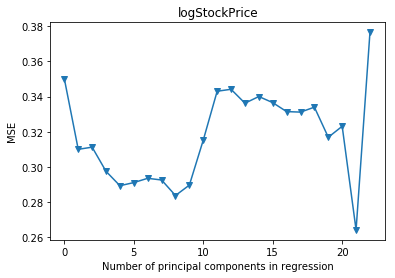

In [35]:
# 10-fold CV, with shuffle
n = len(log_X_reduced)
kf_10 = model_selection.KFold( n_splits=10, shuffle=True)
y=log_train_set['logStockPrice']

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*model_selection.cross_val_score(regr, np.ones((n,1)), y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 22 principle components, adding one component at the time.
for i in np.arange(1, 23):
    score = -1*model_selection.cross_val_score(regr, log_X_reduced[:,:i], y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
# Plot results    
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('logStockPrice')
plt.xlim(xmin=-1)
plt.show()

In [47]:
import statsmodels.api as sm
num_comp=9
log_pcr_model = sm.OLS(y, sm.add_constant(log_X_reduced[:,:num_comp]))
results = log_pcr_model.fit()
print (results.summary())

                            OLS Regression Results                            
Dep. Variable:          logStockPrice   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     14.66
Date:                Mon, 05 Feb 2018   Prob (F-statistic):           5.07e-21
Time:                        10:58:58   Log-Likelihood:                -369.43
No. Observations:                 480   AIC:                             758.9
Df Residuals:                     470   BIC:                             800.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5150      0.024    145.868      0.0

# Predictive measure by MSE
* Based on the testing set, the MSE of all the methods:


In [61]:
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
log_mse_lasso = mean_squared_error(log_test_set['logStockPrice'], log_lasso_fit.predict(log_test_set[log_test_set.columns[1:23]]))
log_mse_forward=mean_squared_error(log_test_set['logStockPrice'], log_forward_var.predict(log_test_set[log_test_set.columns[1:23]]))
log_mse_best=mean_squared_error(log_test_set['logStockPrice'],log_best_subset_m.predict(sm.add_constant(log_test_set[log_test_set.columns[log_best_subset_index]])))

log_X_reduced_test = log_pca.transform(scale(log_test_set[log_test_set.columns[1:23]]))[:,:num_comp]
regr = LinearRegression()
regr.fit(log_X_reduced[:,:num_comp], y)
pred = regr.predict(log_X_reduced_test)
log_mse_pcr=mean_squared_error(log_test_set['logStockPrice'], pred)

print ('MSE.best.subset: %.5f'% log_mse_best)
print ('MSE.forward: %.5f'% log_mse_forward)
print ('MSE.lasso: %.5f'% log_mse_lasso)
print ('MSE.pcr: %.5f'% log_mse_pcr)

MSE.best.subset: 0.26331
MSE.forward: 0.25982
MSE.lasso: 0.27773
MSE.pcr: 0.29231


# VIF
* Multicollinearity causes unreliable coefficient estimates
* One may use VIF to detect multicollinearity
    * The larger the VIF, the stronger the collinearity
* the function below is used to calculate the VIF

In [57]:
import statsmodels.formula.api as sm
def vif_cal(input_data):
    x_vars=input_data
    xvar_names=x_vars.columns
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]] 
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.ols(formula="y~x", data=x_vars).fit().rsquared  
        vif=round(1/(1-rsq),2)
        print (xvar_names[i], " VIF = " , vif)

In [58]:
print ('VIF for best subset')
vif_cal(log_train_set[log_train_set.columns[log_best_subset_index]])

print ('\nVIF for forward')
vif_cal(log_train_set[list(dict(log_forward_var.params).keys())[1:]])

print ('\nVIF for LASSO')
temp={log_train_set.columns[i]:log_lasso_fit.coef_[i-1]  for i in range(1,23) if log_lasso_fit.coef_[i-1]!=0}
vif_cal(log_train_set[list(temp.keys())])

VIF for best subset
logTotalDebt  VIF =  1.41
logRevenues  VIF =  289.06
logBVofAssets  VIF =  8.89
logNetIncome  VIF =  5.92
logCashPctOfFirmValue  VIF =  3.41
logCashPctOfRevenues  VIF =  3.69
logCapitalExpenditures  VIF =  1.61
logTrailingRevenues  VIF =  296.64

VIF for forward
logNetIncome  VIF =  19.93
logRevenues  VIF =  296.19
logTrailingRevenues  VIF =  296.76
logCapitalExpenditures  VIF =  1.61
logCashPctOfFirmValue  VIF =  3.42
logBVofAssets  VIF =  8.79
logCashPctOfRevenues  VIF =  3.73
logDebtRatio  VIF =  1.23
logNetMargin  VIF =  4.8

VIF for LASSO
logTotalDebt  VIF =  1.44
logROE  VIF =  2.34
logROC  VIF =  1.65
logNetMargin  VIF =  1.81
logNetIncome  VIF =  2.34
logCashPctOfFirmValue  VIF =  1.1
logCapitalExpenditures  VIF =  1.62


* Notice that some of the VIFs from forward/best subset are very large!
    * Since some of them are mathematically related by design
* Multicollinearity does not exist for principal component regression by design
    * Each component is uncorrelated with each other
* Conclusion: If we take both mse and multicollinearity into consideration, then LASSO may be a better choice in this example

# Business Implications
* Let’s review the estimated coefficients from LASSO (based on the log transformed data)

* Suppose a company is going to be listed in a stock exchange, we may use this model to predict the stock price by given its financial indicators
* Consider PerkinElmer Inc. (i.e. the first company in our testing data) with its financial indicators:

In [59]:
PerkinElmer=log_test_set.head(1)[log_test_set.columns[1:23]]
PerkinElmer

,logTotalDebt,logCash,logRevenues,logROE,logROC,logNetMargin,logInvestedCapital,logBVofAssets,logNetIncome,logEBIT,...,logCashPctOfRevenues,logCashPctOfTotalAssets,logCapitalExpenditures,logDepreciation,logTrailingRevenues,logTrailingNetIncome,logIntangibleAssetsToTotalAssets,logFixedAssetsToTotalAssets,logDebtEquityRatio,logDebtRatio
480,5.925859,5.285739,7.430826,-2.659246,-2.207266,-2.813394,7.400743,7.853799,4.588024,5.534377,...,-2.207266,-2.525716,2.944439,4.333361,7.452054,4.588024,-0.562117,-2.407934,-2.120255,-1.609433


* We may use **predict()** function to predict the StockPrice:

In [60]:
log_lasso_fit.predict(PerkinElmer)

array([ 3.44925618])

* Result in 3.4493 (in log scale), so the predicted price is 31.4784
* Suppose we are the stock holder of a company, then we may concern how to boost the stock price:
    * Recall log to log model corresponds to percentage change in the original scale
    * So the estimated coefficients will answer this question

* By keeping other variables to be the same level, then
    * 1% increase in NetIncome, it is expected to have 0.1266% increase in the StockPrice
    * 1% decreases in CapitalExpenditures, it is expected to have 0.0039% increase in the StockPrice
    * and etc.,
    * So the managers/executives may think about the way of increasing net income and the reduction of capital expenditures 